# Estimating deformation length scaling parameter
Points to consider
- previous work has used binning instead
- clauset et al describing issues with power law binning and with multiple distributions having the straight line in log-log coords
- our goal is to avoid binning the data and instead use all of the data within a sample using maximum likelihood
- the log-normal distribution requires the least assumptions about the data
- not too hard to compute the moments of the distribution also

## Hutchings et al. 2024
Hutchings et al. 2024 challenges the prevailing viewpoint that sea ice deformation is scale invariant. Their work leverages GPS drifters with very low position uncertainty to examine scaling behavior at smaller scales than has been previously possible. They divided the data into 100 bins, evenly spaced in log-space from 200 m to 100 km. They find that a linear fit is only appropriate for length scales larger than 10 km, which is near the lower limit for our dataset. 

## Additional analysis
In the initial submission, we calculate a scaling parameter using MLE using data spanning all length bins by first scaling the data by the square root of the area enclosed by the array. 

1. Reproduce initial results (minimum angle = 20, random sampling)
2. Check whether results change with minimum angle = 30.
3. Investigation of the departure from the log normal distribution -- any coherent reasons?
4. 

In [1]:
import pandas as pd
import proplot as pplt
import numpy as np

In [262]:
# all_results = pd.read_csv('../data/deformation/ift_deformation_calculations_2003.csv')
# all_results['datetime'] = pd.to_datetime(all_results['datetime'].values)
all_results['year'] = all_results.datetime.dt.month
all_results['month'] = all_results.datetime.dt.month

logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
all_results['L'] = np.sqrt(all_results['triangle_area_km2'])
all_results['log_bin'] = np.digitize(all_results['L'], logbins)

In [ ]:
%run ../scripts/06_deformation_calculation.py

In [266]:
def normal_log_likelihood(eps, L, beta):
    n = len(eps)
    data = np.log(eps*L**beta)
    mu = np.mean(data)
    sigma = np.std(data)    
    normalizer = -n/2*np.log(2*np.pi*sigma**2)
    return normalizer - np.sum(data - mu)**2/(2*sigma**2)   

# Make monthly sample set
rs = 32413
n = 1000
samples = {4: {}, 5: {}, 6: {}}
for (year, month, log_bin), group in all_results.groupby(['year', 'month', 'log_bin']):
    if len(group) > 1000:
        if log_bin > 0:
            if month in samples:   
                if year not in samples[month]:
                    samples[month][year] = []
                samples[month][year].append(group.sample(n, replace=False, random_state=rs + month + log_bin))
for month in samples:
    for year in samples[month]:
        samples[month][year] = pd.concat(samples[month][year])

In [268]:
pd.concat(samples[month]).reset_index(drop=True)

,floe_id1,latitude1,longitude1,x1,y1,u1,v1,u_nsidc1,v_nsidc1,nsidc_sic1,...,datetime,month,year,divergence,vorticity,pure_shear,normal_shear,total_deformation,L,log_bin
0,2017_05248,77.48928,-10.86717,-262885.628305,-1.369371e+06,0.048116,0.057894,0.044,-0.002,0.97000,...,2017-06-01 12:00:00,6,6,2.681909e-07,-3.844078e-06,3.940861e-06,-1.844398e-06,2.175557e-06,10.488088,1
1,2020_08997,72.44622,-20.56117,-685693.182104,-1.828018e+06,-0.093078,-0.055069,NaN,NaN,0.74081,...,2020-06-30 12:00:00,6,6,2.677919e-06,-3.930503e-07,3.367718e-06,1.056130e-06,1.764719e-06,11.401754,1
2,2019_04671,78.77585,-4.41552,-96352.325342,-1.247791e+06,0.001552,-0.013849,-0.004,-0.015,0.91948,...,2019-06-11 12:00:00,6,6,-1.496633e-06,-6.635670e-06,-3.743983e-06,-4.508953e-06,2.930361e-06,13.784049,1
3,2017_04816,77.48886,-8.55226,-207366.653656,-1.378918e+06,0.068682,0.086096,0.053,0.039,0.85000,...,2017-06-02 12:00:00,6,6,-2.529114e-06,-2.659844e-06,3.085688e-06,1.409947e-06,1.696277e-06,12.649111,1
4,2003_06266,72.31243,-18.72500,-631504.540449,-1.863023e+06,0.017421,-0.105408,-0.023,-0.018,0.77000,...,2003-06-07 12:00:00,6,6,1.002881e-06,6.604118e-06,-2.820540e-06,-6.156993e-06,3.386149e-06,12.247449,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2003_05516,77.34863,-8.18776,-200806.390306,-1.395612e+06,0.009853,-0.009598,0.018,-0.035,0.78000,...,2003-06-01 12:00:00,6,6,1.708480e-07,1.815196e-07,2.053937e-07,3.605361e-07,2.074686e-07,300.599401,10
9996,2019_04415,82.43854,-18.60814,-269285.775423,-7.997906e+05,0.011409,-0.001391,NaN,NaN,1.00000,...,2019-06-11 12:00:00,6,6,9.371330e-08,6.911554e-09,-6.221470e-09,7.762007e-08,3.893450e-08,490.051018,10
9997,2019_04358,79.72303,-0.44552,-8912.632746,-1.146180e+06,-0.030443,-0.079823,0.004,-0.011,0.98007,...,2019-06-11 12:00:00,6,6,1.914903e-07,-4.229772e-07,3.284625e-09,5.412156e-08,2.711057e-08,444.600945,10
9998,2019_04502,77.00256,-12.02701,-301802.363113,-1.416584e+06,-0.016722,-0.030203,-0.008,-0.047,0.96000,...,2019-06-11 12:00:00,6,6,1.019763e-07,-6.737838e-08,1.814578e-08,5.958574e-09,9.549529e-09,303.364467,10


In [125]:
# Build bootstrap analysis of slopes
bs_table = []
for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    bs_results = []
    for repeat in range(10):
        resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)
        likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
        for beta in likelihood_results.index:
            likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                                 resamp['L'], beta)
        bs_results.append(likelihood_results.idxmax())
    del likelihood_results
    q1, q2 = np.quantile(np.array(bs_results), [0.025, 0.975])
    bs_table.append([month, q1, q2])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta', 'max_beta']).set_index('month')
bs_table['beta'] = np.nan
for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta'] = beta

In [126]:
bs_table

,min_beta,max_beta,beta
month,,,
4,0.503632,0.538954,0.522412
5,0.604249,0.625765,0.616935
6,0.614198,0.665564,0.646784


# How well does the lognormal model explain the deformation distribution?

If the deformation distribution is actually well described by a lognormal distribution, then we expect that we can apply the transformation (choice of beta and division by the length scale) and get normally distributed data. A key result is that we are able to estimate a reasonable value for beta, for the marginal ice zone, in this way; however, we find that 

In [308]:
month = 6
strat_samp = pd.concat(samples[month], axis=0)


In [309]:
strat_samp['min_coast_dist'] = strat_samp[['coast_dist_km1', 'coast_dist_km2', 'coast_dist_km3']].min(axis=1)
strat_samp['min_edge_dist'] = strat_samp[['edge_dist_km1', 'edge_dist_km2', 'edge_dist_km3']].min(axis=1)

In [271]:
all_results['min_coast_dist'] = all_results[['coast_dist_km1', 'coast_dist_km2', 'coast_dist_km3']].min(axis=1)
all_results['min_edge_dist'] = all_results[['edge_dist_km1', 'edge_dist_km2', 'edge_dist_km3']].min(axis=1)

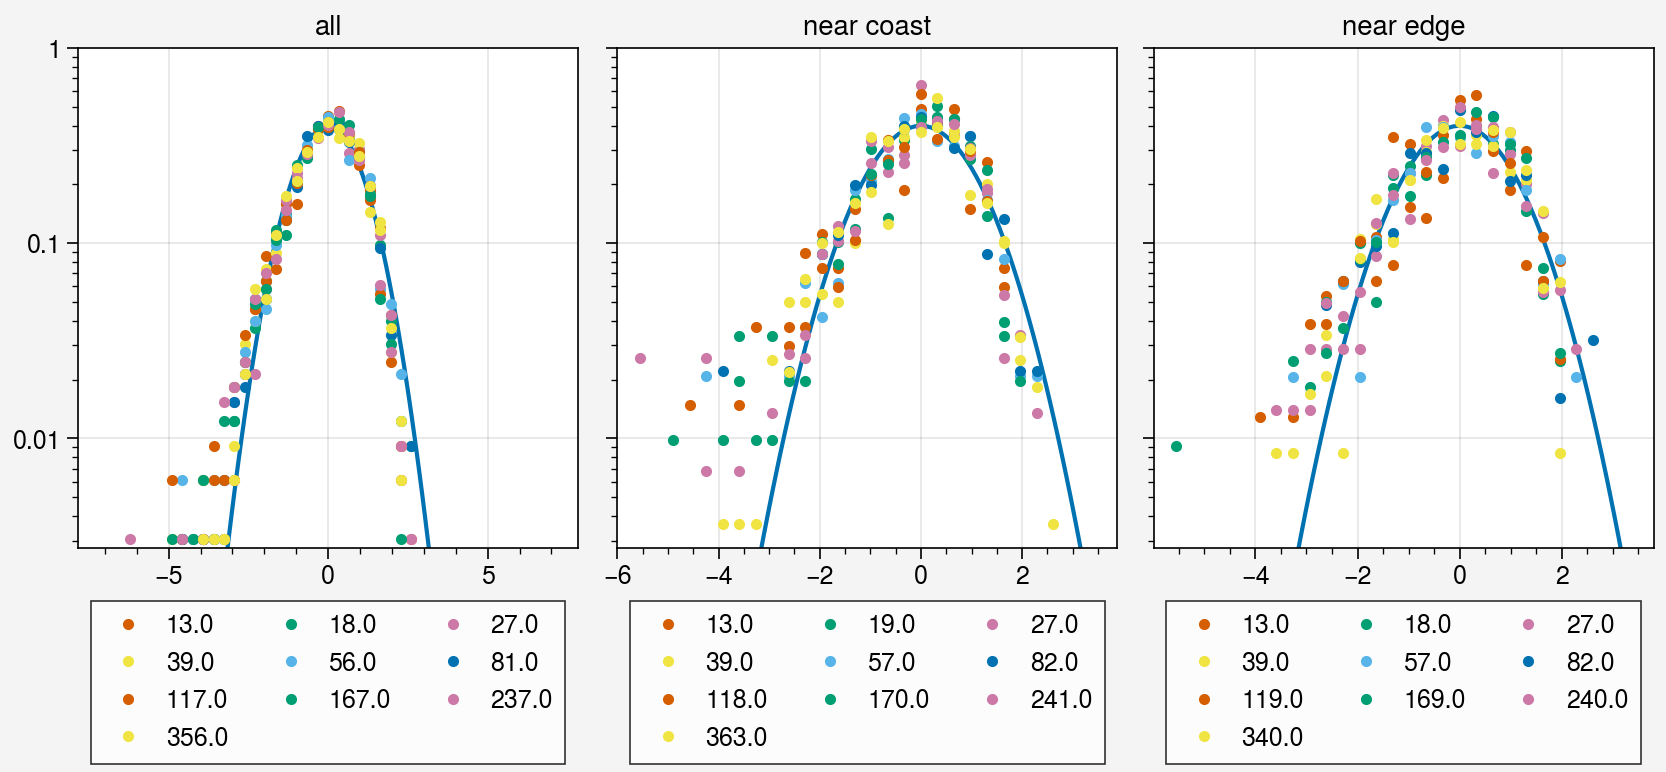

In [310]:
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
fig, axs = pplt.subplots(ncols=3)

for ax, subset_idx, title in zip(axs, [strat_samp.min_coast_dist.notnull(),
                                strat_samp.min_coast_dist <= 100,
                                strat_samp.min_edge_dist <= 100],
                          ['all', 'near coast', 'near edge']):
    x = np.linspace(-4, 4, 100)
    ax.plot(x, normal_dist(x))
    for lbin, subset in strat_samp.loc[subset_idx].groupby('log_bin'):
        eps = subset['total_deformation']
        L = subset['L']
        n = len(eps)
        data = np.log(eps*L**-0.6)
        # adjust for skewed data
        q1, q2 = data.quantile([0.1, 0.9])
        mu = np.mean(data[(data > q1) & (data < q2)])
        std = np.std(data[(data > q1) & (data < q2)])
        
        pdf, x_bins = np.histogram((data-mu)/np.std(data), bins=np.linspace(-8, 8, 50), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        ax.plot(x_center, pdf, marker='.', lw=0, label=np.round(np.mean(L)))
        ax.format(yscale='log', ylim=(1/n, 1), title=title)
    ax.legend(loc='b')

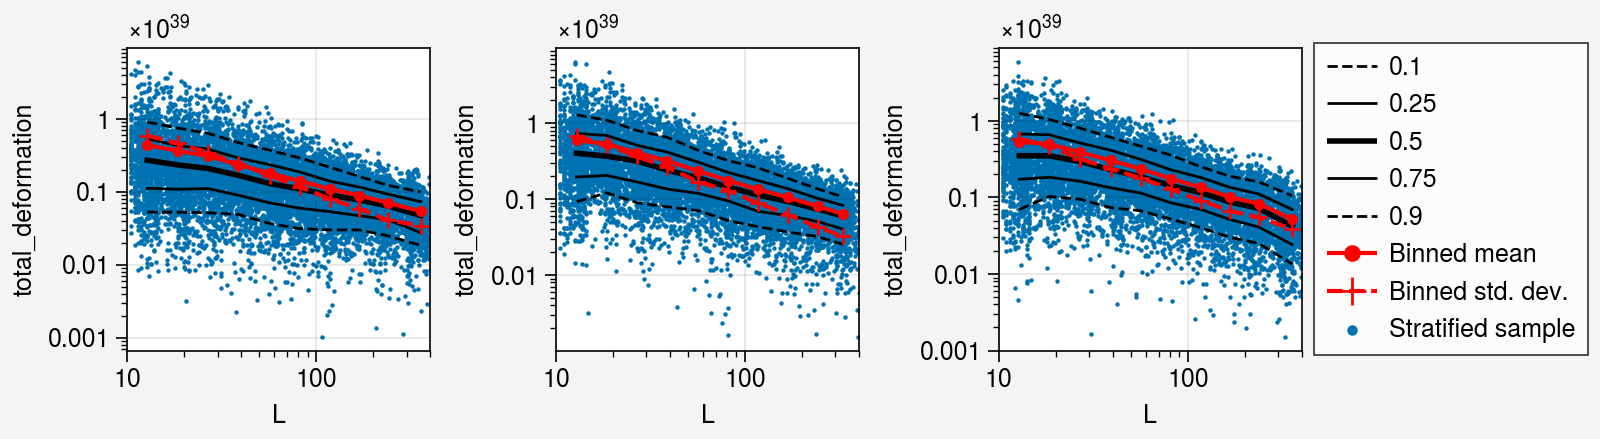

In [311]:
fig, axs = pplt.subplots(width=8, ncols=3, share=False)
for ax, month in zip(axs, samples):
    strat_samp = pd.concat(samples[month])
    # Estimating quantiles
    results = strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    bins = strat_samp[['log_bin', 'L']].groupby('log_bin').mean()
    n = strat_samp[['log_bin', 'L']].groupby('log_bin').count()
    results.index.names = ['log_bin', 'quantile']
    results = results.pivot_table(index='log_bin', columns='quantile', values='total_deformation')
    results.index = bins.loc[results.index,:].values.squeeze()
    
    # Estimating quantiles
    results_mean = strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').mean()
    results_mean.index = bins.loc[results_mean.index,:].values.squeeze()
    results_std = strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').std()
    results_std.index = bins.loc[results_std.index,:].values.squeeze()
    ax.scatter(strat_samp['L'], strat_samp['total_deformation'], marker='o', ms=1, label='Stratified sample')
    for quantile, ls, lw in zip(results.columns, ['--', '-', '-', '-', '--'], [1, 1, 2, 1, 1]):
        ax.plot(results.index, results[quantile], marker='', ls=ls, lw=lw, color='k')
        ax.format(yscale='log', xscale='log')
    ax.plot(results_mean.index, results_mean, marker='.', color='r', label='Binned mean')
    ax.plot(results_std.index, results_std, marker='+', color='r', ls='--', label='Binned std. dev.')
    ax.format(xlim=(10, 400))
ax.legend(loc='r', ncols=1, ms=10)

In [196]:
from scipy.stats import linregress

In [233]:
linear_fit = linregress(x=np.log(results_mean.index.values), y=np.log(results_mean.values.squeeze()))
print(np.round(linear_fit.slope, 3))

-0.609


In [234]:
linear_fit = linregress(x=np.log(results[0.5].index.values), y=np.log(results[0.5].values.squeeze()))
print(np.round(linear_fit.slope, 3))

-0.512


In [232]:
bs_table

,min_beta,max_beta,beta
month,,,
4,0.503632,0.538954,0.522412
5,0.604249,0.625765,0.616935
6,0.614198,0.665564,0.646784


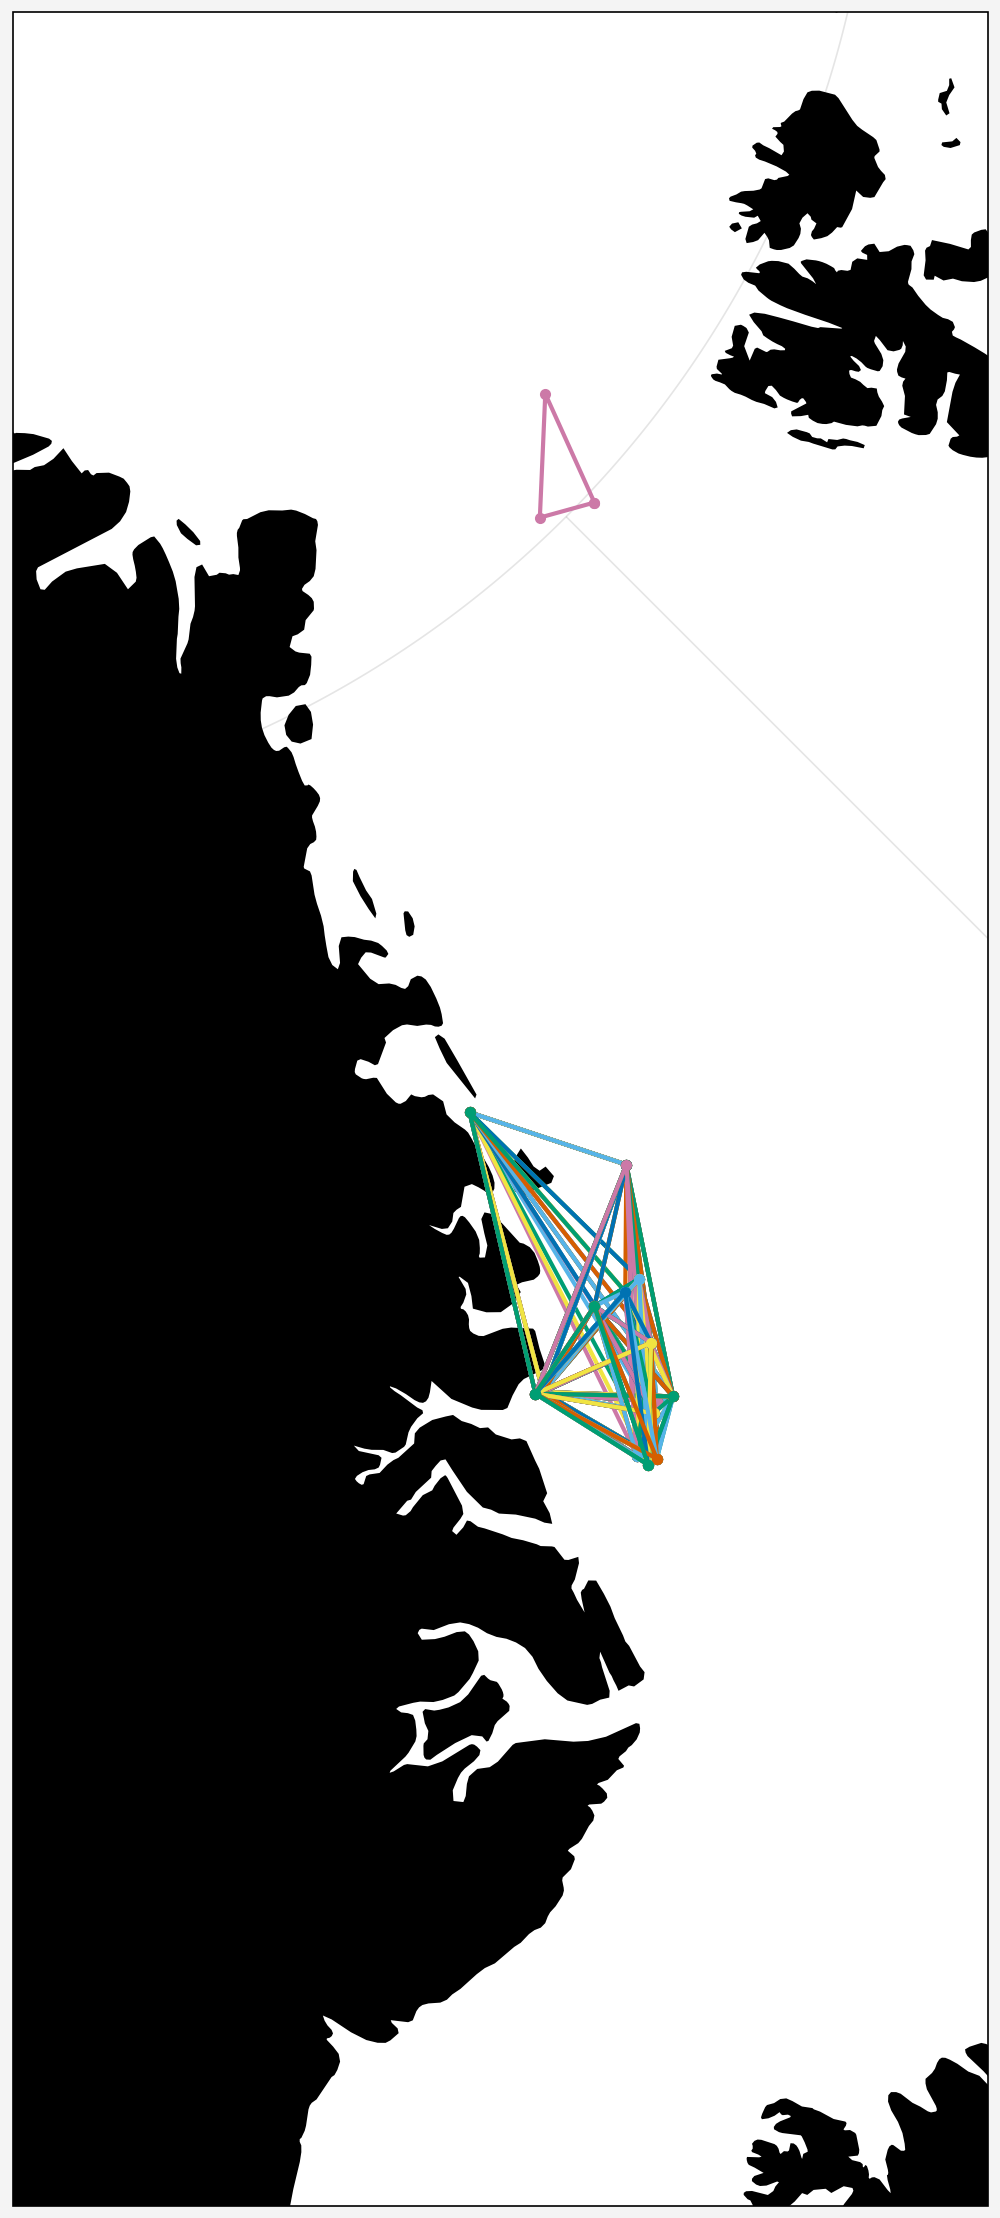

In [250]:
for date, day_df in all_results.groupby('datetime'):
    if len(day_df) > 20:
        break

import cartopy.crs as ccrs
import warnings
warnings.simplefilter('ignore')

pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, axs = pplt.subplots(width=5, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.25e6], crs=crs)        
for idx, row in day_df.iterrows():
    # axs.plot([row.x1, row.x2, row.x3, row.x1],
    #         [row.y1, row.y2, row.y3, row.y1], m='.', transform=crs)
    axs.plot([row.longitude1, row.longitude2, row.longitude3, row.longitude1],
        [row.latitude1, row.latitude2, row.latitude3, row.latitude1], m='.')

In [301]:
test = '2003_00067'
comp = all_results.loc[((all_results.floe_id1 == test) | (all_results.floe_id2 == test)) | (all_results.floe_id3 == test)]
comp

,floe_id1,latitude1,longitude1,x1,y1,u1,v1,u_nsidc1,v_nsidc1,nsidc_sic1,...,year,divergence,vorticity,pure_shear,normal_shear,total_deformation,L,log_bin,min_coast_dist,min_edge_dist
98,2003_00067,79.90240,1.6066,31576.854432,-1.125822e+06,-0.118513,-0.284706,-0.103,-0.252,0.80,...,4,3.727190e-07,-8.818716e-07,7.610709e-07,-0.000002,9.199914e-07,60.663004,5,217.500000,91.099998
178,2003_00067,79.67656,1.0832,21766.049533,-1.151176e+06,-0.150125,-0.352101,-0.143,-0.271,0.78,...,4,6.518602e-07,-9.132186e-07,1.539966e-07,-0.000002,9.342119e-07,62.209324,5,212.199997,81.300003
179,2003_00090,79.52819,-3.3655,-68560.757275,-1.165866e+06,-0.115429,-0.315690,-0.105,-0.267,0.92,...,4,4.903433e-07,-1.257088e-06,1.306701e-07,-0.000001,7.446223e-07,42.661458,4,226.399994,81.300003
180,2003_00090,79.52819,-3.3655,-68560.757275,-1.165866e+06,-0.115429,-0.315690,-0.105,-0.267,0.92,...,4,8.935310e-07,-1.099248e-06,-1.469032e-07,-0.000002,9.109486e-07,73.280284,6,212.199997,81.300003


In [257]:
all_results.loc[:, ['x1', 'total_deformation']].notnull().sum()

x1                   2806591
total_deformation    1217395
dtype: int64

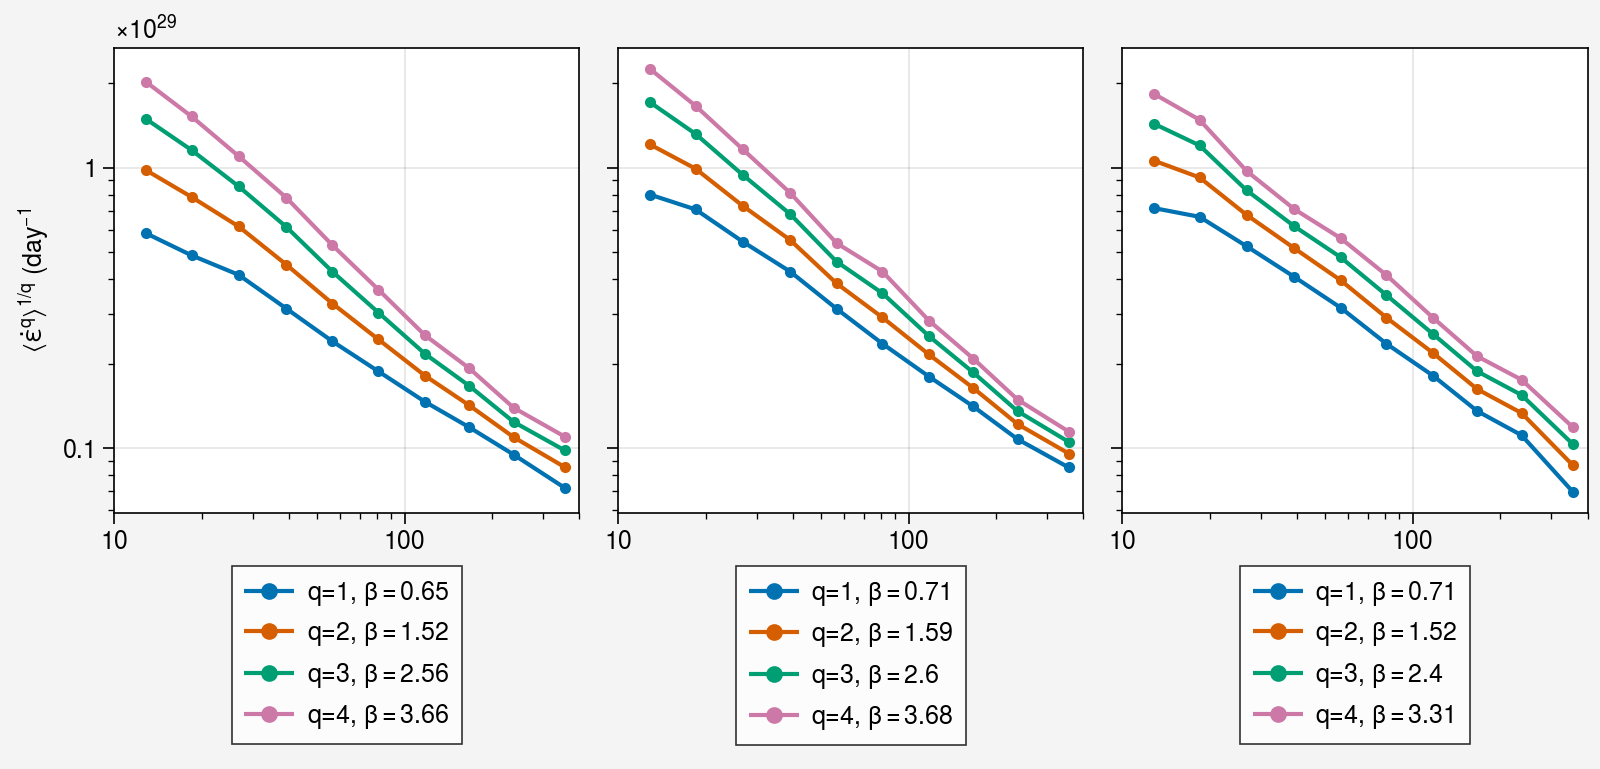

In [314]:
fig, axs = pplt.subplots(width=8, ncols=3, sharex=False)
for ax, month in zip(axs, samples):
    strat_samp = pd.concat(samples[month])
    strat_samp['total_deformation'] *= 60*60*24 # Convert to per day
    # # Estimating quantiles
    # results = strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    # bins = strat_samp[['log_bin', 'L']].groupby('log_bin').mean()
    # n = strat_samp[['log_bin', 'L']].groupby('log_bin').count()
    # results.index.names = ['log_bin', 'quantile']
    # results = results.pivot_table(index='log_bin', columns='quantile', values='total_deformation')
    # results.index = bins.loc[results.index,:].values.squeeze()
    
    # Estimating quantiles
    for q in [1, 2, 3, 4]:
        strat_samp['eps_q'] = strat_samp['total_deformation']**q
        results_mean = strat_samp[['log_bin', 'eps_q']].groupby('log_bin').mean()
        results_mean.index = bins.loc[results_mean.index,:].values.squeeze()
        linear_fit = linregress(x=np.log(results_mean.index.values), y=np.log(results_mean.values.squeeze()))
        b = -np.round(linear_fit.slope, 2)
        results_std = strat_samp[['log_bin', 'eps_q']].groupby('log_bin').std()
        results_std.index = bins.loc[results_std.index,:].values.squeeze()    
        ax.plot(results_mean.index, results_mean**(1/q), marker='.', label='q={q}, $\\beta={b}$'.format(q=q, b=b))
    # ax.plot(results_std.index, results_std, marker='+', color='r', ls='--', label='Binned std. dev.')
    ax.format(xlim=(10, 400), yscale='log', xscale='log', ylabel='$\\langle \dot{\epsilon}^q\\rangle^{1/q}$ (day$^{-1}$')
    ax.legend(loc='b', ncols=1, ms=10)

In [299]:
day_df.sort_values('latitude1')[::-1]

,Unnamed: 0,floe_id1,latitude1,longitude1,x1,y1,u1,v1,u_nsidc1,v_nsidc1,...,year,divergence,vorticity,pure_shear,normal_shear,total_deformation,L,log_bin,min_coast_dist,min_edge_dist
105,105,2003_00067,79.90240,1.60660,31577.0,-1125822.0,-0.118513,-0.284706,-0.103,-0.252,...,2003,3.727209e-07,-8.818727e-07,7.610723e-07,-1.675202e-06,9.199908e-07,60.663004,5,217.500000,91.099998
21,21,2003_00002,75.92190,-19.12528,-513788.0,-1481616.0,-0.000565,0.001267,NaN,NaN,...,2003,NaN,NaN,NaN,NaN,NaN,134.944433,7,42.400002,229.300003
19,19,2003_00002,75.92190,-19.12528,-513788.0,-1481616.0,-0.000565,0.001267,NaN,NaN,...,2003,5.096128e-07,-1.520014e-06,-1.177598e-06,-1.088447e-06,8.017877e-07,139.212068,7,42.400002,253.699997
20,20,2003_00002,75.92190,-19.12528,-513788.0,-1481616.0,-0.000565,0.001267,NaN,NaN,...,2003,1.303403e-07,-1.180303e-06,-6.809914e-07,-9.760477e-07,5.950669e-07,137.695316,7,42.400002,182.000000
22,22,2003_00002,75.92190,-19.12528,-513788.0,-1481616.0,-0.000565,0.001267,NaN,NaN,...,2003,2.063473e-07,-1.035001e-06,-6.767483e-07,-8.121206e-07,5.285660e-07,127.906216,7,42.400002,201.399994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,2003_00083,72.25177,-18.91578,-639873.0,-1867237.0,NaN,NaN,-0.057,-0.142,...,2003,NaN,NaN,NaN,NaN,NaN,100.498756,7,42.400002,182.000000
91,91,2003_00083,72.25177,-18.91578,-639873.0,-1867237.0,NaN,NaN,-0.057,-0.142,...,2003,NaN,NaN,NaN,NaN,NaN,82.583291,6,42.400002,233.899994
89,89,2003_00083,72.25177,-18.91578,-639873.0,-1867237.0,NaN,NaN,-0.057,-0.142,...,2003,NaN,NaN,NaN,NaN,NaN,93.968080,6,42.400002,201.399994
87,87,2003_00083,72.25177,-18.91578,-639873.0,-1867237.0,NaN,NaN,-0.057,-0.142,...,2003,NaN,NaN,NaN,NaN,NaN,83.486526,6,42.400002,229.300003


# Sampling unique polygons rather than sampling from the full set of all polygons




In [315]:
all_floes = []
all_floes.append([x for x in np.unique(all_results['floe_id1'])])
all_floes.append([x for x in np.unique(all_results['floe_id2'])])
all_floes.append([x for x in np.unique(all_results['floe_id3'])])

In [318]:
X = np.unique(all_floes[0] + all_floes[1] + all_floes[2])

array(['2003_00002', '2003_00005', '2003_00035', ..., '2020_09844',
       '2020_09850', '2020_09862'], dtype='<U10')